In [1]:
%load_ext autotime
%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Load modules

In [50]:
# встроенные
import os
from pathlib import Path
from typing import List

# внешние
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

time: 21.9 ms


# Settings

In [6]:
sns.set()

time: 1.81 ms


# Constants 

In [170]:
path_dats = Path('dataset')
output_folder = Path('output')
crops = sorted(os.listdir(path_dats))
crops

['Бодяк',
 'Бодяк_гер',
 'Горшок',
 'Костер',
 'Костер_гер',
 'Марь',
 'Марь_гер',
 'Одуванчик',
 'Одуванчик_гер',
 'Озимая_гер',
 'Озимая_засуха',
 'Озимая_пшеница',
 'Паст_сум',
 'Паст_сум_гер',
 'Почва',
 'Почва_гер',
 'Ромашка',
 'Ромашка_гер',
 'Яровой ячмень',
 'Ячмень_гер']

time: 1.83 ms


# helpers

In [8]:
def parse_filename(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    
    if s.split('/'):
        s = s.split('/')[-1]
    
    info = s.split('__')
    return info[0][:3] + info[1]

time: 678 µs


In [9]:
def get_reflection_path(crop: str) -> List[str]:
    return sorted(
        list(
            (path_dats / crop).glob('*.txt')
        ), key=lambda r: int(parse_filename(r)[3:])
    )

time: 972 µs


In [10]:
def read_csv(path: str, name: str='sample', thresholds: List[int]=[450, 950]) -> pd.DataFrame:
    df = pd.read_csv(path, 
                 sep="\t",  
                 error_bad_lines=False, 
                 skiprows=14, 
                 names=['wave', name])

    convert_to_float = lambda s: float(s.replace(',', '.'))

    df['wave'] = df.wave.apply(convert_to_float)
    df[name] = df[name].apply(convert_to_float)
    
    df = df[(df.wave >= thresholds[0]) & (df.wave <= thresholds[1])]
    df[name][df[name] < 0] = 0

    return df.set_index('wave')

time: 1.19 ms


In [96]:
def calc_heatmap(data: pd.Series) -> np.ndarray:
    ar = data.median(axis=1).to_numpy().reshape(-1, 16)
#     ar = np.where(ar < 0, 0, ar)
#     ar = np.where(ar > 200, 200, ar)
#     ar /= ar.max()
#     ar = (ar * 255).astype(np.uint8)
    return ar

time: 585 µs


# Test

In [15]:
{
    crop:len(get_reflection_path(crop))
    for crop in crops
}

{'Бодяк': 6000,
 'Бодяк_гер': 6000,
 'Горшок': 6000,
 'Костер': 6000,
 'Костер_гер': 6000,
 'Марь': 6000,
 'Марь_гер': 6000,
 'Одуванчик': 6000,
 'Одуванчик_гер': 6000,
 'Озимая_гер': 6000,
 'Озимая_засуха': 6000,
 'Озимая_пшеница': 6000,
 'Паст_сум': 6000,
 'Паст_сум_гер': 6000,
 'Почва': 6000,
 'Почва_гер': 6000,
 'Ромашка': 6000,
 'Ромашка_гер': 6000,
 'Яровой ячмень': 6000,
 'Ячмень_гер': 6000}

time: 659 ms


In [155]:
crop = 'Озимая_пшеница'
s = get_reflection_path(crop)[1]
read_csv(s).head()

,sample
wave,
450.311,0.88
450.680,2.40
451.049,2.30
451.417,3.05
451.786,1.29


time: 38.2 ms


# Analysing some sample

## steps

чтобы повсем файлам не бежать выберу оптимальный шаг

In [156]:
steps = np.linspace(10, 1000, 10)
df = pd.DataFrame()

for step in tqdm(steps):
    paths_refl = get_reflection_path(crop)[::int(step)]
    data = pd.concat([ 
            read_csv(path, name=parse_filename(path)) for path in paths_refl
            ], axis=1
    )
    
    stats = data.describe().median(axis=1)
    stats.name = step
    df = df.join(stats.to_frame(), how='right')

100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

time: 5.55 s


In [147]:
df

,10.0,120.0,230.0,340.0,450.0,560.0,670.0,780.0,890.0,1000.0
count,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000
mean,40.352640,40.756233,36.487952,36.902716,41.226513,42.011975,42.375565,43.377922,45.856769,34.210223
std,35.368799,35.167486,33.395598,31.852264,35.962156,36.713428,37.051586,36.807840,41.645674,28.710288
min,1.510000,1.525000,1.600000,1.290000,1.550000,1.940000,1.830000,1.470000,1.140000,1.670000
25%,4.582500,4.573750,4.697500,4.061250,4.813750,4.767500,5.287500,4.113750,4.752500,4.596250
50%,25.332500,25.495000,24.845000,21.492500,26.367500,28.235000,27.340000,25.995000,27.835000,24.390000
75%,78.271250,78.201250,72.357500,70.303750,79.655000,81.002500,82.000000,82.736250,90.312500,64.482500
max,92.945000,93.305000,85.170000,84.040000,94.465000,99.380000,94.710000,97.170000,107.530000,78.385000


time: 10.3 ms


Исследуем образцы с шагом 120

In [157]:
paths_refl = get_reflection_path(crop)[::120]

data = pd.concat([ 
        read_csv(path, name=parse_filename(path)) for path in paths_refl
        ], axis=1
)
data

,Ref0,Ref120,Ref240,Ref360,Ref480,Ref600,Ref720,Ref840,Ref960,Ref1080,...,Ref4800,Ref4920,Ref5040,Ref5160,Ref5280,Ref5400,Ref5520,Ref5640,Ref5760,Ref5880
wave,,,,,,,,,,,,,,,,,,,,,
450.311,1.70,2.61,1.40,3.53,1.94,1.69,1.86,0.47,0.67,1.34,...,0.90,1.48,1.02,1.18,1.31,1.49,1.09,0.00,1.12,1.62
450.680,1.25,1.93,2.92,3.22,2.16,1.51,2.79,0.72,0.80,1.95,...,0.44,0.83,0.32,1.55,0.73,1.75,1.23,0.93,0.46,2.03
451.049,2.00,2.92,4.17,3.28,3.07,1.41,3.40,1.75,3.36,2.56,...,2.59,0.49,1.68,3.12,0.70,4.64,1.52,2.00,2.24,4.27
451.417,2.86,1.85,3.25,4.78,2.37,0.68,4.23,2.13,1.79,2.59,...,2.36,1.63,2.66,1.75,2.45,3.95,0.83,2.37,1.58,2.78
451.786,1.41,0.44,2.58,2.67,1.71,0.98,1.37,1.21,0.23,1.89,...,1.06,1.23,1.85,0.94,0.96,1.51,0.63,0.39,1.53,2.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948.688,56.86,65.37,78.48,78.90,59.09,77.03,77.77,99.16,63.34,75.22,...,69.88,35.72,54.57,59.87,63.13,68.92,39.49,19.92,42.88,66.50
948.979,63.48,55.26,79.44,64.43,55.22,74.89,83.67,94.00,54.36,65.22,...,81.40,16.61,66.25,70.56,67.11,64.79,46.68,1.95,50.95,69.21
949.271,49.24,61.23,80.79,80.22,52.09,84.75,63.24,98.02,71.88,80.63,...,72.91,34.33,62.43,65.90,64.66,61.71,34.71,14.55,43.05,64.59


time: 345 ms


## Stats

In [158]:
data.describe().T.sort_values(by='min', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Ref2760,1504.0,17.143158,6.112238,8.41,11.2800,15.575,22.8700,36.28
Ref1920,1504.0,32.872726,27.256241,2.86,5.3875,21.715,61.4525,86.87
Ref3960,1504.0,25.867500,20.553087,2.09,5.2200,18.395,47.6800,60.58
Ref360,1504.0,38.774315,33.186378,1.90,5.0150,27.095,73.8725,89.35
Ref5880,1504.0,31.784209,27.966573,1.57,3.5600,20.430,61.2825,72.01
Ref5400,1504.0,31.488032,27.168061,1.49,3.9475,21.205,60.1625,74.55
Ref240,1504.0,38.561822,33.929883,1.40,4.1500,25.710,74.4825,90.28
Ref720,1504.0,35.590392,31.956528,1.37,3.4900,21.140,69.6350,86.75
Ref2160,1504.0,38.905246,35.121819,1.29,3.5000,23.010,76.4100,93.53
Ref1200,1504.0,38.218584,34.289060,1.13,3.9375,22.480,74.8125,88.89


time: 84.3 ms


* Экземляр под номер 2760 у пшеницы, поехавший какой-то

In [159]:
data.describe().median(axis=1)

count    1504.000000
mean       29.239638
std        26.392053
min         0.150000
25%         2.700000
50%        17.617500
75%        57.176250
max        70.160000
dtype: float64

time: 76.5 ms


## Display data

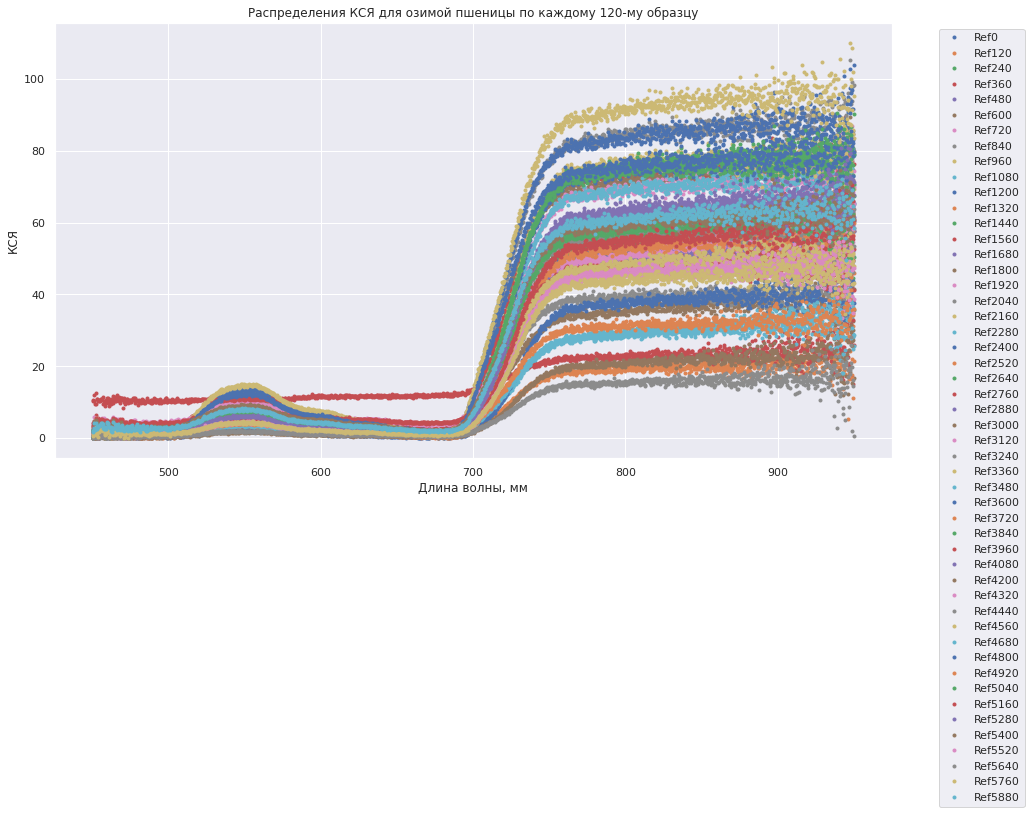

time: 856 ms


In [161]:
ax = data.plot(style='.', legend=True, figsize=(15, 8))
ax.set_title('Распределения КСЯ для озимой пшеницы по каждому 120-му образцу')
ax.set_ylabel('КСЯ')
ax.set_xlabel('Длина волны, мм')
ax.legend(bbox_to_anchor=(1.05, 1))

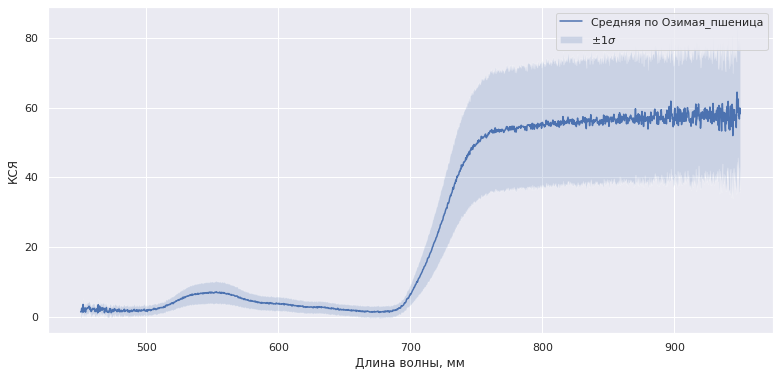

time: 201 ms


In [25]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

std = data.std(axis=1)
mean = data.mean(axis=1)

mean.plot(ax=ax, label=f'Средняя по {crop}')

ax.fill_between(mean.index, y1=mean + std, y2=mean - std, alpha=0.2, label='$\pm 1 \sigma$')
ax.set_ylabel('КСЯ')
ax.set_xlabel('Длина волны, мм')

ax.legend()

## Display boxplot

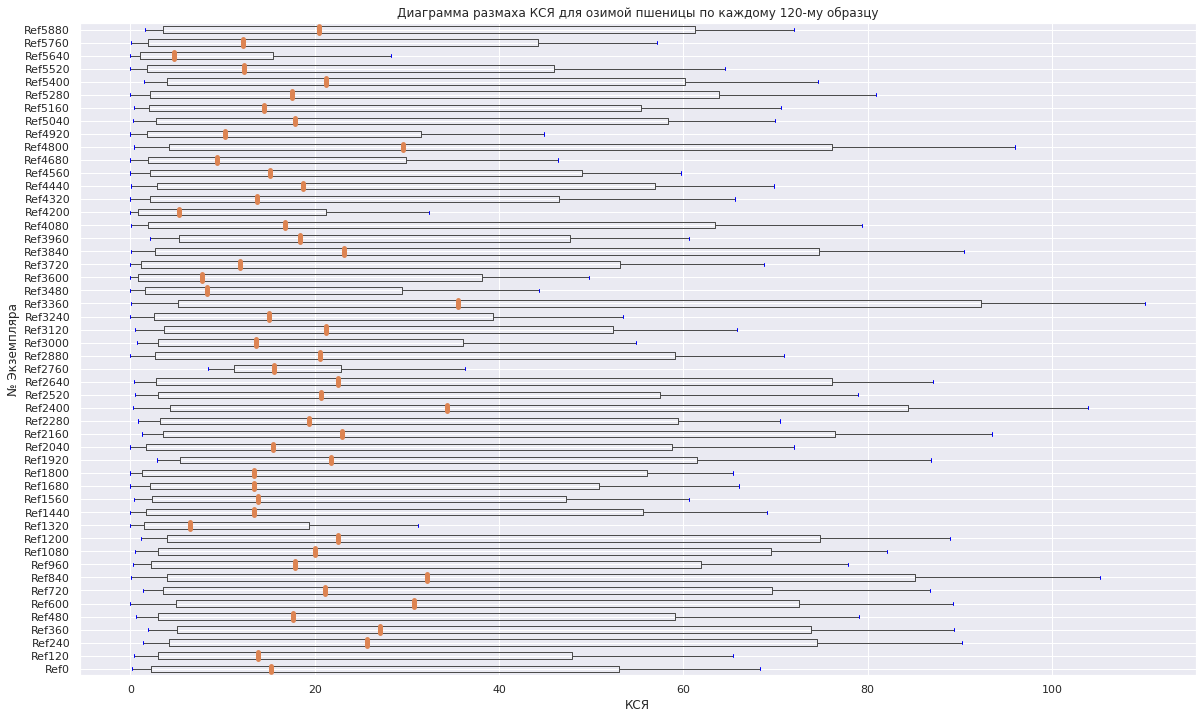

time: 709 ms


In [29]:
ax = data.boxplot(rot=0, whis=[0, 100], figsize=(20, 12), 
             color={'medians': 'red', 'caps': 'blue'},
             medianprops={'linewidth': 5},
            vert=False)
ax.set_title('')
ax.set_ylabel('№ Экземпляра')
ax.set_xlabel('КСЯ')
ax.set_title("Диаграмма размаха КСЯ для озимой пшеницы по каждому 120-му образцу")
plt.show()

# Проход по всем культурам

In [166]:
df = pd.DataFrame()

for crop in tqdm(crops):
    paths_refl = get_reflection_path(crop)[::240]
    data = pd.concat([ 
            read_csv(path, name=parse_filename(path)) for path in paths_refl
            ], axis=1
    )
    
    stats = data.describe().median(axis=1)
    stats.name = crop
    df = df.join(stats.to_frame(), how='right')

100%|██████████| 20/20 [00:04<00:00,  4.74it/s]

time: 4.22 s


In [167]:
df

,Бодяк,Бодяк_гер,Горшок,Костер,Костер_гер,Марь,Марь_гер,Одуванчик,Одуванчик_гер,Озимая_гер,Озимая_засуха,Озимая_пшеница,Паст_сум,Паст_сум_гер,Почва,Почва_гер,Ромашка,Ромашка_гер,Яровой ячмень,Ячмень_гер
count,1504.000000,1504.000000,1504.00000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000
mean,15.631423,22.599428,1.19367,14.349801,14.378477,12.874674,11.482234,22.770638,22.631423,29.001576,36.764455,31.149707,22.183311,17.832234,4.108723,3.652141,21.357633,20.754422,40.706170,39.177340
std,10.989853,15.296785,1.34294,11.237010,10.716973,9.575245,7.533568,18.148759,17.442724,26.024671,33.309628,27.331225,15.305342,11.612371,3.235851,3.279397,13.939526,14.741960,36.790615,33.774957
min,0.930000,1.830000,0.00000,0.680000,0.610000,1.140000,1.060000,0.760000,0.820000,0.000000,0.260000,0.190000,1.730000,1.890000,0.000000,0.000000,2.300000,2.200000,1.240000,1.650000
25%,4.625000,6.042500,0.71000,2.940000,2.887500,3.467500,3.560000,4.222500,4.577500,2.500000,3.187500,2.670000,6.427500,5.802500,1.650000,1.440000,6.457500,5.370000,4.867500,4.435000
50%,17.095000,24.100000,0.87000,11.920000,12.350000,12.825000,12.205000,22.745000,21.645000,17.060000,21.590000,17.840000,24.155000,19.745000,2.970000,2.550000,23.125000,21.000000,23.495000,24.215000
75%,26.567500,38.382500,1.17000,25.560000,24.760000,21.892500,18.660000,40.962500,40.102500,55.955000,71.712500,61.452500,35.950000,28.502500,5.755000,5.112500,34.710000,35.152500,79.567500,74.620000
max,41.350000,54.370000,15.93000,41.960000,41.280000,36.840000,32.810000,58.960000,55.560000,71.500000,85.520000,79.020000,50.860000,47.620000,24.240000,24.810000,50.560000,52.000000,94.400000,89.900000


time: 16.2 ms


### checkpoint

In [172]:
df.to_csv(output_folder / "median_stats_spectr_crop.csv")

time: 3.59 ms


## Stats

Text(0, 0.5, 'КСЯ')

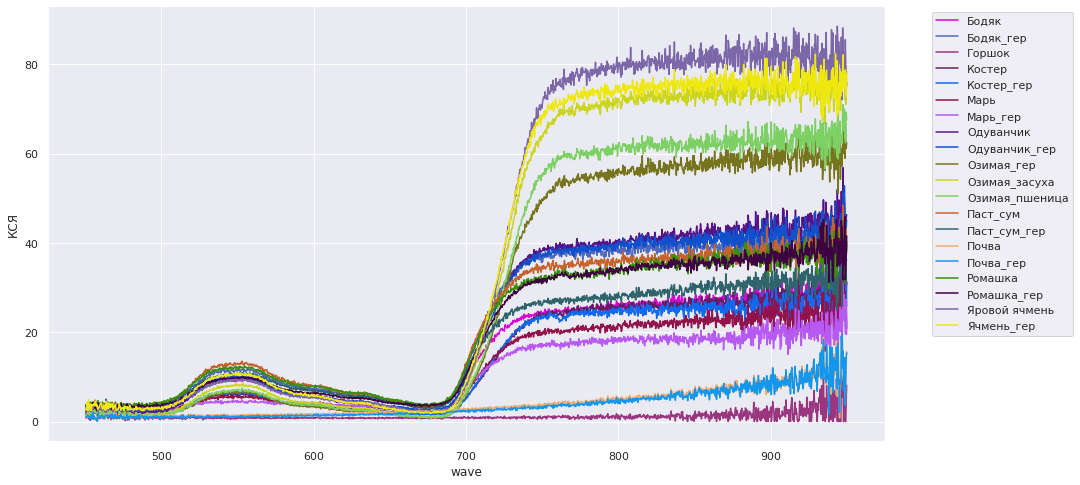

time: 7.11 s


In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
get_rand_color = lambda: f'#{np.random.randint(256**3):06x}'

for crop in crops:
    
    paths_refl = get_reflection_path(crop)[::240]

    data = pd.concat([ 
            read_csv(path, name=parse_filename(path)) for path in paths_refl
            ], axis=1
    )
    
    data.median(axis=1).plot(ax=ax, label=crop, color=get_rand_color())
    ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_ylabel('КСЯ')
    


## Heatmap 

Идея заключается в том, чтобы сжать признаки, получить новые данные, и по ним строить модель

Я подумал, что будет лучше построить типа "матрицы", и потом у нее выделить две главные компоненты, которые будут максимально описывать данные, и уже их отправлять на трейн.

1504 признак (число спектральных каналов) можно представить в виде матрицы размером (16x94). И если строить две компоненты по матрице такой размерности, то для трейна уже будет матрица 2x16 (вместо 2x1504), или просто вектор длиной в 32 элемента. Но это пока просто эксперимент, может я хрень делаю, но надо сначал это попробовать

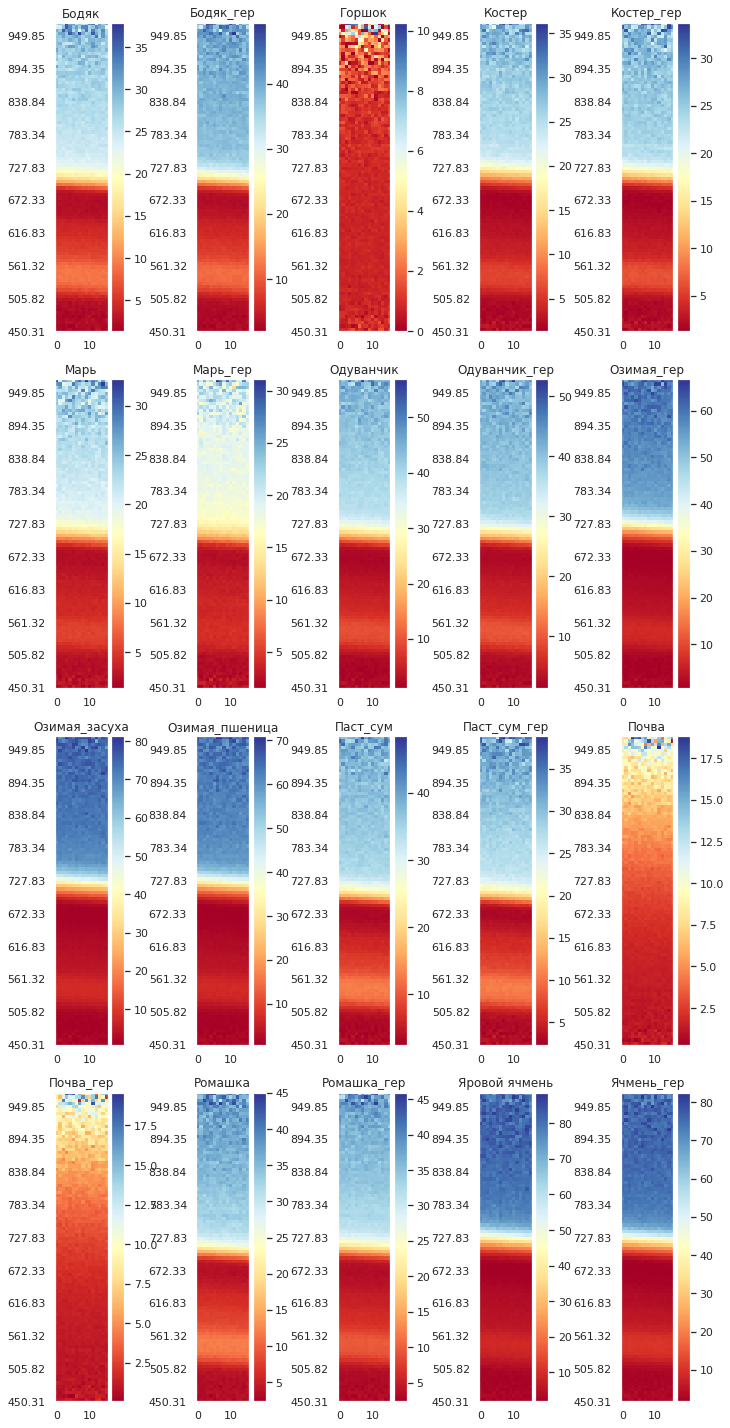

time: 6.61 s


In [135]:
fig, axs = plt.subplots(4, 5, figsize=(10, 20))


for ax, crop in zip(axs.flat, crops):
    paths_refl = get_reflection_path(crop)[::240]

    data = pd.concat([ 
                read_csv(path, name=parse_filename(path)) for path in paths_refl
            ], axis=1
    )


    heat = calc_heatmap(data)

    ax.grid(False)
    ax.set_title(crop)
    im = ax.imshow(heat, cmap='RdYlBu')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='25%', pad=0.05)

    lim = ax.get_ylim()
    ax.set_yticks(np.arange(lim[1], lim[0], 10))

    ytickslabel = np.linspace(data.index.min(), data.index.max(), 10)

    ax.set_yticklabels(ytickslabel.round(2))
    ax.set_ylim(ax.get_ylim()[::-1])

    fig.colorbar(im, cax=cax)

fig.tight_layout()

## МГК 

20it [52:54, 158.75s/it]


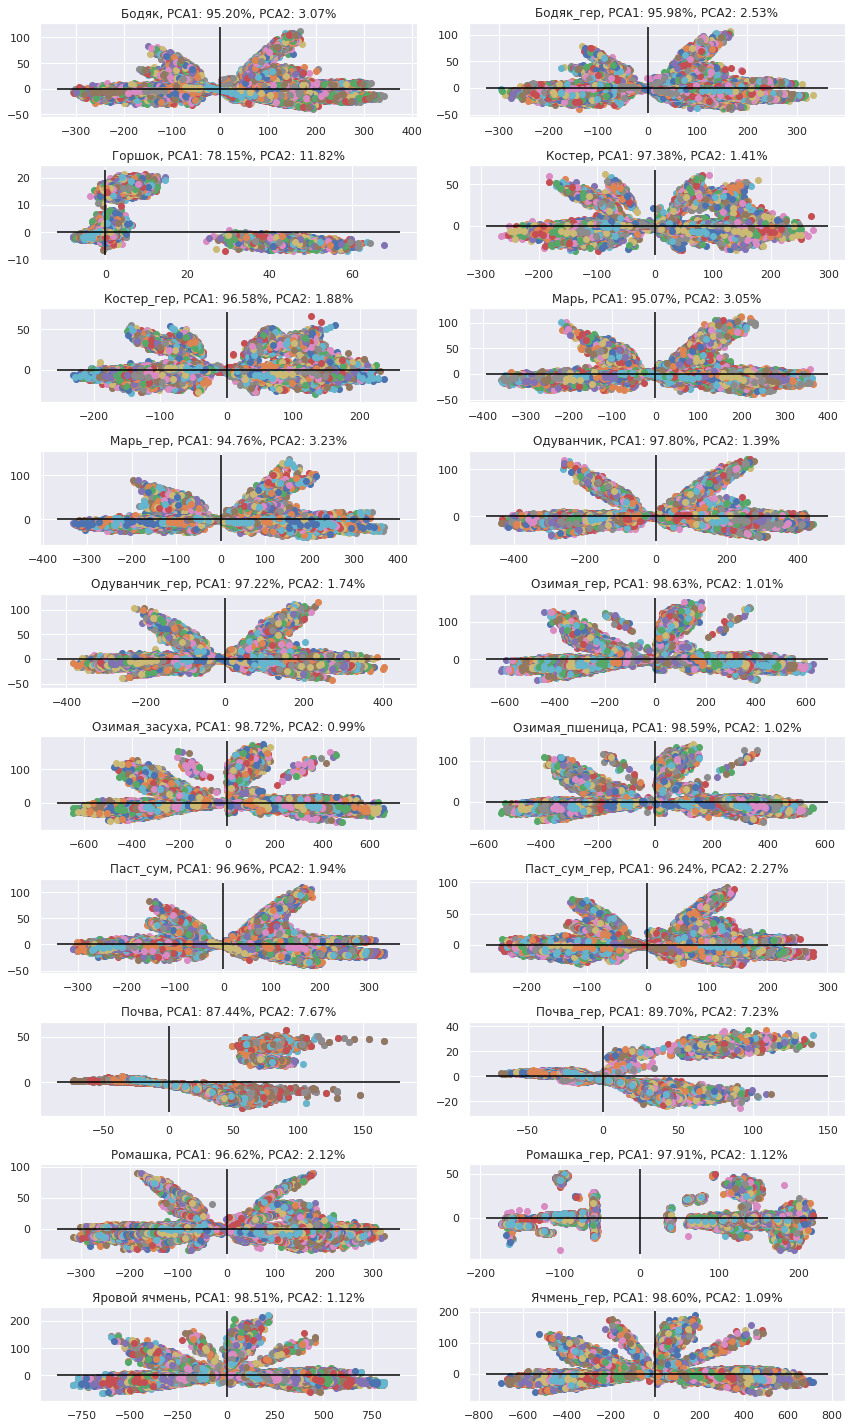

time: 1h 8min 19s


In [235]:
fig, axs = plt.subplots(len(crops) // 2, 2, figsize=(12, 20))
df = pd.DataFrame()

for ax, crop in tqdm(zip(axs.flat, crops)):
    explained = []
    paths_refl = get_reflection_path(crop)

    data = pd.concat([ 
            read_csv(path, name=parse_filename(path)) for path in paths_refl
            ], axis=1
    )

    pca = PCA(n_components=2)

    for col in data.columns:
        sample = data[col].to_numpy().reshape(-1, 94) # 1504 
        pca_res = pca.fit(sample)
        trans_data = pca_res.transform(sample)
        x_label = [f'x{idx}' for idx in range(trans_data.size)]
        
        frame = list(zip(x_label, trans_data.flatten()))
        frame.append(['y', crop])
        
        df = df.append(pd.DataFrame([dict(frame)]), ignore_index=True)
        
        
        explained.append(pca_res.explained_variance_ratio_)

        ax.scatter(x=trans_data[:, 0], y=trans_data[:, 1])


    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    ax.vlines(x=0, ymin=ylim[0], ymax=ylim[1], color='black')
    ax.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black')
    
    mean = np.mean(explained, axis=0)
    ax.set_title(f'{crop}, PCA1: {mean[0] * 100:.2f}%, PCA2: {mean[1] * 100:.2f}%')
    
plt.tight_layout()

# checkpoint

In [266]:
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63
0,-20.996218,3.320365,-21.355476,3.447383,-20.318654,3.208967,-19.523336,3.040217,-18.766463,2.601593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-31.382738,4.086684,-29.959691,3.924474,-25.887168,3.285712,-25.233219,3.089735,-26.024995,3.453667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21.156204,3.341130,-20.529874,3.088691,-16.373749,2.738338,-16.720627,2.706476,-17.559738,2.672651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-32.145846,4.797973,-30.754883,4.593709,-22.608526,2.851133,-22.682206,2.860715,-25.122497,3.370372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-34.818909,3.512130,-33.201523,2.879485,-26.907120,2.364460,-25.859794,1.919653,-27.375917,2.363553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,659.224882,-26.157946,641.131277,-4.548353,501.868064,7.379154,514.603777,-58.253157,589.664426,-36.424198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119996,-473.857203,-18.875567,-466.677220,-5.574797,-385.915054,1.076381,-392.634349,-37.832874,-436.472086,-24.142827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119997,-447.148705,-18.431207,-440.731563,-6.385513,-367.613769,0.548639,-376.686088,-35.864726,-418.166069,-22.616090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119998,-397.004654,-16.015030,-391.455870,-6.826965,-337.704476,-2.144927,-342.947988,-28.442008,-372.821174,-19.008792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 26.6 ms


In [237]:
df['y'].unique()

array(['Бодяк', 'Бодяк_гер', 'Горшок', 'Костер', 'Костер_гер', 'Марь',
       'Марь_гер', 'Одуванчик', 'Одуванчик_гер', 'Озимая_гер',
       'Озимая_засуха', 'Озимая_пшеница', 'Паст_сум', 'Паст_сум_гер',
       'Почва', 'Почва_гер', 'Ромашка', 'Ромашка_гер', 'Яровой ячмень',
       'Ячмень_гер'], dtype=object)

time: 6.93 ms


* почему-то длина вектора в некоторых образцах более 32

In [270]:
df.dropna()['y'].unique()

array(['Почва'], dtype=object)

time: 18.5 ms


Косяк с почвой вышел, потому что индексы Reflection повторяются в названиях файла

In [274]:
df = df[df['y'] != 'Почва'][df.columns[:33]]
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,y
0,-20.996218,3.320365,-21.355476,3.447383,-20.318654,3.208967,-19.523336,3.040217,-18.766463,2.601593,...,-5.323830,16.413220,-5.783452,25.573636,-10.827591,33.879059,-16.784916,62.423120,22.389374,Бодяк
1,-31.382738,4.086684,-29.959691,3.924474,-25.887168,3.285712,-25.233219,3.089735,-26.024995,3.453667,...,-5.546749,22.516820,-8.769609,32.097992,-9.025819,46.126416,-14.482830,74.906072,26.008449,Бодяк
2,-21.156204,3.341130,-20.529874,3.088691,-16.373749,2.738338,-16.720627,2.706476,-17.559738,2.672651,...,-5.621250,16.615480,-5.801033,23.112644,-10.974166,31.786227,-15.077515,54.709753,23.635544,Бодяк
3,-32.145846,4.797973,-30.754883,4.593709,-22.608526,2.851133,-22.682206,2.860715,-25.122497,3.370372,...,-6.088425,20.482177,-7.464388,29.544139,-10.222043,35.437699,-15.050007,70.567899,28.276639,Бодяк
4,-34.818909,3.512130,-33.201523,2.879485,-26.907120,2.364460,-25.859794,1.919653,-27.375917,2.363553,...,-5.958023,27.266871,-6.015011,30.182456,-8.617242,39.693505,-13.309326,59.458916,30.146494,Бодяк


time: 65.8 ms


In [276]:
crop = 'Почва'
paths_refl = get_reflection_path(crop)

data = pd.concat([ 
        read_csv(path, name=parse_filename(path)) for path in paths_refl
        ], axis=1
)



time: 35 s


In [279]:
data.columns = [f'{c}_{idx}' for idx, c in enumerate(data.columns)]

time: 6.24 ms


In [281]:
data.head()

,Ref0_0,Ref0_1,Ref1_2,Ref1_3,Ref2_4,Ref2_5,Ref3_6,Ref3_7,Ref4_8,Ref4_9,...,Ref3990_5990,Ref3991_5991,Ref3992_5992,Ref3993_5993,Ref3994_5994,Ref3995_5995,Ref3996_5996,Ref3997_5997,Ref3998_5998,Ref3999_5999
wave,,,,,,,,,,,,,,,,,,,,,
450.311,0.81,1.12,1.11,0.47,1.30,2.02,1.80,1.43,3.10,0.03,...,1.11,1.95,1.04,1.15,1.34,1.94,1.34,0.97,0.90,1.17
450.680,1.32,1.37,1.75,1.64,2.58,0.96,1.23,1.32,1.59,0.66,...,0.86,0.99,0.99,1.86,1.50,0.57,0.90,0.52,1.21,1.59
451.049,1.65,1.53,1.06,2.25,0.67,1.29,1.53,2.16,1.68,1.81,...,1.45,0.74,1.23,0.03,1.01,1.57,0.98,0.96,0.83,1.42
451.417,1.75,1.39,1.44,1.51,3.18,1.09,0.94,1.30,2.25,2.19,...,1.84,1.62,1.37,0.50,1.26,0.70,0.69,1.90,0.33,1.85
451.786,2.49,2.06,2.20,2.47,1.47,1.10,2.37,1.85,1.73,1.67,...,1.83,2.05,0.94,1.46,2.72,1.05,2.18,1.31,1.53,1.51


time: 53.6 ms


In [282]:
 for col in tqdm(data.columns):
    sample = data[col].to_numpy().reshape(-1, 94) # 1504 
    pca_res = pca.fit(sample)
    trans_data = pca_res.transform(sample)
    x_label = [f'x{idx}' for idx in range(trans_data.size)]
    
    assert trans_data.size == 32

    frame = list(zip(x_label, trans_data.flatten()))
    frame.append(['y', crop])

    df = df.append(pd.DataFrame([dict(frame)]), ignore_index=True)

100%|██████████| 6000/6000 [00:36<00:00, 165.28it/s]

time: 36.3 s


In [283]:
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,y
0,-20.996218,3.320365,-21.355476,3.447383,-20.318654,3.208967,-19.523336,3.040217,-18.766463,2.601593,...,-5.323830,16.413220,-5.783452,25.573636,-10.827591,33.879059,-16.784916,62.423120,22.389374,Бодяк
1,-31.382738,4.086684,-29.959691,3.924474,-25.887168,3.285712,-25.233219,3.089735,-26.024995,3.453667,...,-5.546749,22.516820,-8.769609,32.097992,-9.025819,46.126416,-14.482830,74.906072,26.008449,Бодяк
2,-21.156204,3.341130,-20.529874,3.088691,-16.373749,2.738338,-16.720627,2.706476,-17.559738,2.672651,...,-5.621250,16.615480,-5.801033,23.112644,-10.974166,31.786227,-15.077515,54.709753,23.635544,Бодяк
3,-32.145846,4.797973,-30.754883,4.593709,-22.608526,2.851133,-22.682206,2.860715,-25.122497,3.370372,...,-6.088425,20.482177,-7.464388,29.544139,-10.222043,35.437699,-15.050007,70.567899,28.276639,Бодяк
4,-34.818909,3.512130,-33.201523,2.879485,-26.907120,2.364460,-25.859794,1.919653,-27.375917,2.363553,...,-5.958023,27.266871,-6.015011,30.182456,-8.617242,39.693505,-13.309326,59.458916,30.146494,Бодяк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,-27.188383,4.289911,-27.713985,3.690225,-27.083990,3.545892,-25.394216,3.209124,-23.913261,2.950759,...,-5.724630,21.941503,-8.624379,33.824219,-10.744942,46.033673,-14.724251,77.209174,24.036396,Почва
119996,-26.382910,4.005052,-26.331223,4.171987,-25.415274,3.901036,-23.991097,3.501103,-22.284316,3.136611,...,-5.967334,22.541547,-7.194254,30.490853,-11.644794,41.348836,-18.229992,71.126247,26.797285,Почва
119997,-27.197277,3.299572,-26.643511,3.673539,-25.698991,3.846172,-24.116822,3.029318,-22.471340,2.664172,...,-5.742204,21.835012,-6.933752,32.304516,-8.252351,40.924304,-20.008208,70.799909,25.717980,Почва
119998,-27.361845,3.757682,-26.613921,3.831866,-25.641554,3.836229,-24.161546,3.124428,-22.770133,3.030148,...,-5.781223,22.726172,-6.624008,31.563174,-10.015170,42.573726,-17.414066,70.777135,25.742098,Почва


time: 28.5 ms


In [284]:
df.to_csv(output_folder / 'train_test.csv')

time: 3.51 s
